# Post-Transformation Modeling Notebook

## Importing Packages

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from utils import *

%reload_ext autoreload
%autoreload 2


## Augmentation through ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
model = create_model((224, 224, 3))
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [82]:
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = train_generator,
                              epochs = 20,
                              steps_per_epoch = len(train_generator),
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator)

## Augmentation through Albumentations

In [4]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 1506 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [5]:
X_tr, y_tr = next(train_generator)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(test_generator)

## CNN Model

This model was inspired by the VGG16 model which was the only one that seemed to produce any normal metrics

In [4]:
model2 = create_model((256, 256, 3))
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve = 'PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [5]:
filepath = '../models/CNN_original.h5'
earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
history2 = model2.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save],
                     validation_data = val_generator)

Epoch 1/20
428/428 [==============================] - 4308s 10s/step - loss: 9.3389 - accuracy: 0.8453 - auc: 0.8187 - auc_1: 0.9056 - precision: 0.8978 - recall: 0.8975 - val_loss: 530.1702 - val_accuracy: 0.1282 - val_auc: 0.4651 - val_auc_1: 0.8342 - val_precision: 0.2105 - val_recall: 0.0031
Epoch 2/20
428/428 [==============================] - 3512s 8s/step - loss: 0.6581 - accuracy: 0.8798 - auc: 0.9037 - auc_1: 0.9642 - precision: 0.9022 - recall: 0.9470 - val_loss: 0.2545 - val_accuracy: 0.9110 - val_auc: 0.9015 - val_auc_1: 0.9798 - val_precision: 0.9232 - val_recall: 0.9785
Epoch 3/20
428/428 [==============================] - 3379s 8s/step - loss: 0.3595 - accuracy: 0.9104 - auc: 0.9329 - auc_1: 0.9717 - precision: 0.9208 - recall: 0.9654 - val_loss: 0.2651 - val_accuracy: 0.9236 - val_auc: 0.9141 - val_auc_1: 0.9812 - val_precision: 0.9267 - val_recall: 0.9900
Epoch 4/20
428/428 [==============================] - 3498s 8s/step - loss: 0.4316 - accuracy: 0.9131 - auc: 0.9281

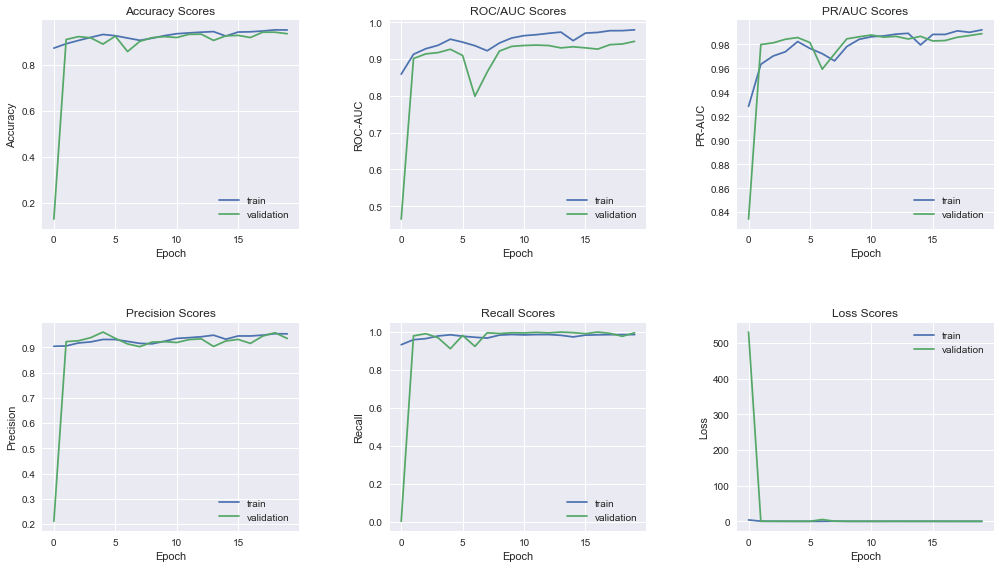

In [8]:
plt.style.use('seaborn')
sixplot(history2, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [31]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,auc,auc_1,precision,recall,val_loss,val_accuracy,val_auc,val_auc_1,val_precision,val_recall
0,4.088655,0.873538,0.858984,0.928289,0.904718,0.932002,530.170166,0.128154,0.465127,0.834200,0.210526,0.003072
1,0.585988,0.892544,0.913018,0.963356,0.905938,0.958317,0.254490,0.911023,0.901481,0.979847,0.923188,0.978495
2,0.395820,0.906871,0.928162,0.970257,0.917871,0.963888,0.265129,0.923639,0.914138,0.981249,0.926671,0.990015
3,0.282272,0.920322,0.937444,0.973830,0.922116,0.977910,0.226879,0.918327,0.917617,0.984241,0.938943,0.968510
4,0.192176,0.933041,0.954082,0.982336,0.931793,0.984057,0.270012,0.891102,0.926745,0.985684,0.961102,0.910906
5,0.221897,0.927485,0.946041,0.976601,0.931477,0.976565,0.235522,0.925631,0.909807,0.981466,0.936217,0.980799
6,0.320801,0.917398,0.936383,0.972220,0.924146,0.971187,5.254061,0.858566,0.798910,0.959308,0.914068,0.923195
7,0.823735,0.907456,0.922623,0.966210,0.916257,0.966769,0.453580,0.903054,0.864759,0.972119,0.903068,0.994624
8,0.245090,0.916667,0.943743,0.978159,0.914373,0.982520,0.235961,0.918991,0.921907,0.984599,0.921429,0.990783
9,0.190809,0.927778,0.957329,0.984174,0.924505,0.985594,0.200266,0.923639,0.934575,0.986305,0.923022,0.994624


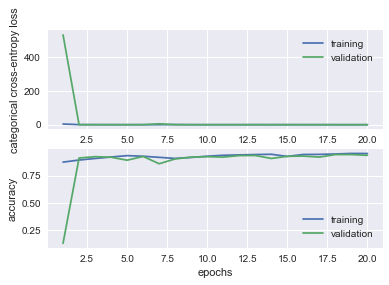

In [32]:
train_val_metrics(20, history2)

In [39]:
score = model2.evaluate(X_tt, y_tt, verbose = 1)
labels = model2.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

7/7 [==============================] - 24s 3s/step - loss: 2.2692 - accuracy: 0.4299 - auc: 0.5457 - auc_1: 0.7858 - precision: 0.7733 - recall: 0.3558
loss: 2.269223213195801
accuracy: 0.42990654706954956


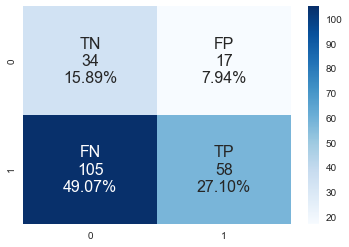

In [35]:
prob = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred2 = prob > 0.5
make_confusion_matrix(y_true, y_pred2)

# VGG16

In [4]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 214,
        class_mode = 'binary',
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 1506 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [5]:
vgg16 = VGG16(include_top = False, 
              weights = 'imagenet', 
              input_shape = (224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False
input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name = 'flatten')(output_)
last_layer = Dense(1, activation = 'sigmoid')(last_layer)
model3 = Model(inputs = input_, outputs = last_layer)
model3.compile(optimizer = Adam(lr = 0.001), 
               loss = 'binary_crossentropy',
               metrics = ['acc', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [12]:
filepath = '../models/VGG16.h5'
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
history3 = model3.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save],
                     validation_data = val_generator)

Epoch 1/20
240/240 [==============================] - 1254s 5s/step - loss: 0.3675 - acc: 0.8505 - auc_2: 0.8737 - auc_3: 0.9047 - precision_1: 0.8603 - recall_1: 0.9298 - val_loss: 0.3550 - val_acc: 0.8409 - val_auc_2: 0.8385 - val_auc_3: 0.9655 - val_precision_1: 0.8826 - val_recall_1: 0.9369
Epoch 2/20
240/240 [==============================] - 1017s 4s/step - loss: 0.1833 - acc: 0.9296 - auc_2: 0.9714 - auc_3: 0.9827 - precision_1: 0.9318 - recall_1: 0.9685 - val_loss: 0.4313 - val_acc: 0.8527 - val_auc_2: 0.8296 - val_auc_3: 0.9596 - val_precision_1: 0.8623 - val_recall_1: 0.9831
Epoch 3/20
240/240 [==============================] - 822s 3s/step - loss: 0.1187 - acc: 0.9544 - auc_2: 0.9914 - auc_3: 0.9957 - precision_1: 0.9538 - recall_1: 0.9807 - val_loss: 0.3566 - val_acc: 0.8527 - val_auc_2: 0.8468 - val_auc_3: 0.9685 - val_precision_1: 0.8841 - val_recall_1: 0.9508
Epoch 4/20
240/240 [==============================] - 954s 4s/step - loss: 0.0991 - acc: 0.9613 - auc_2: 0.9927 -

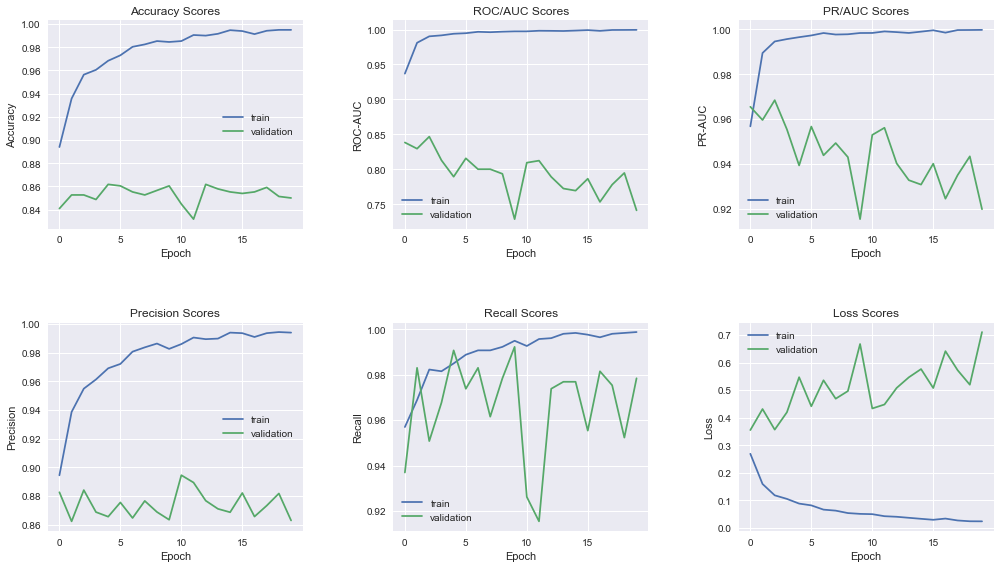

In [16]:
plt.style.use('seaborn-notebook')
sixplot(history3, 'auc_2', 'val_auc_2', 'auc_3', 'val_auc_3', 'precision_1', 'val_precision_1', 'recall_1', 'val_recall_1')

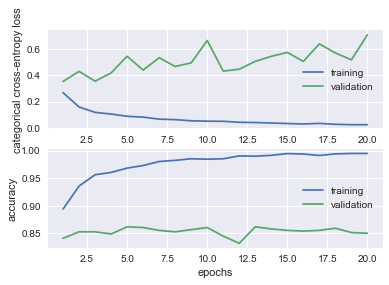

In [23]:
train_val_metrics(20, history3)

In [57]:
hist_df_3 = pd.DataFrame(history3.history)
hist_df_3

,loss,accuracy,auc_6,auc_7,precision_3,recall_3,val_loss,val_accuracy,val_auc_6,val_auc_7,val_precision_3,val_recall_3
0,5.959352,0.744909,0.758642,0.826092,0.810069,0.815982,12.293129,0.951327,0.527995,0.960942,0.959762,0.990769
1,0.610057,0.819582,0.845289,0.887599,0.835203,0.915098,0.224131,0.958702,0.711566,0.980095,0.958702,1.000000
2,0.451655,0.829504,0.879377,0.923176,0.841865,0.922397,0.316067,0.868732,0.631978,0.975656,0.959083,0.901538
3,0.416313,0.856136,0.920728,0.954409,0.859495,0.942374,0.165416,0.957227,0.818736,0.990093,0.958641,0.998462
4,0.328959,0.861097,0.927976,0.957397,0.872348,0.932002,0.277417,0.895280,0.785549,0.988379,0.969206,0.920000
5,0.287642,0.871279,0.935500,0.962636,0.884475,0.932386,0.222067,0.912979,0.751758,0.985440,0.959565,0.949231
6,0.280256,0.857963,0.934572,0.965333,0.874500,0.923550,0.195969,0.939528,0.830494,0.991259,0.959276,0.978462
7,0.392078,0.869452,0.929319,0.960551,0.885589,0.927776,0.431595,0.871681,0.666017,0.964980,0.966833,0.896923


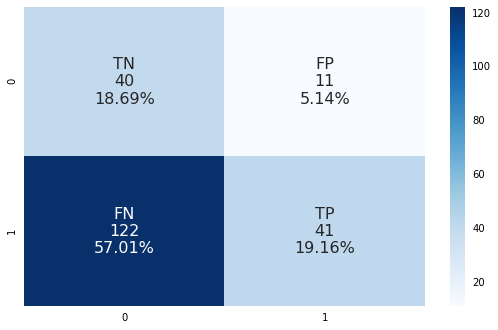

In [58]:
prob = model3.predict_generator(test_generator)
y_true = test_generator.classes
y_pred3 = prob > 0.5
make_confusion_matrix(y_true, y_pred3)

# CNN Model

In [8]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        class_mode = 'binary',
        batch_size = 753,
        seed = 42,
        shuffle = False)

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


In [24]:
def cnn(input_shape):
    return Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Dropout(0.2),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2), 
        MaxPool2D(pool_size=(3, 3)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dropout(0.25),     
        Dense(units=1, activation='sigmoid')
        ])

In [25]:
model5 = cnn((256, 256, 3))
model5.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', keras.metrics.AUC(), keras.metrics.AUC(curve='PR'), keras.metrics.Precision(), keras.metrics.Recall()])

In [28]:
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
# earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
mcp_save = ModelCheckpoint('../models/CNN_v3.h5', 
                           save_best_only = True, 
                           monitor = 'val_loss', 
                           mode = 'min')
tensorboard_cb = TensorBoard(log_dir="../logcnn2")
csv_logger = CSVLogger('../logcnn2/log.csv')
history5 = model5.fit(train_generator,
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger, lr_reduction],
                     validation_data = val_generator,
                     batch_size = 16)

Epoch 1/20
428/428 [==============================] - 2390s 6s/step - loss: 0.3500 - accuracy: 0.8823 - auc_2: 0.8335 - auc_3: 0.9119 - precision_1: 0.8797 - recall_1: 0.9809 - val_loss: 0.3570 - val_accuracy: 0.8818 - val_auc_2: 0.9191 - val_auc_3: 0.9838 - val_precision_1: 0.9577 - val_recall_1: 0.9032
Epoch 2/20
428/428 [==============================] - 2180s 5s/step - loss: 0.2204 - accuracy: 0.9254 - auc_2: 0.9392 - auc_3: 0.9738 - precision_1: 0.9241 - recall_1: 0.9825 - val_loss: 0.2648 - val_accuracy: 0.9336 - val_auc_2: 0.9409 - val_auc_3: 0.9891 - val_precision_1: 0.9374 - val_recall_1: 0.9892
Epoch 3/20
 38/428 [=>............................] - ETA: 38:21 - loss: 0.1776 - accuracy: 0.9492 - auc_2: 0.9503 - auc_3: 0.9791 - precision_1: 0.9457 - recall_1: 0.9911

KeyboardInterrupt: 

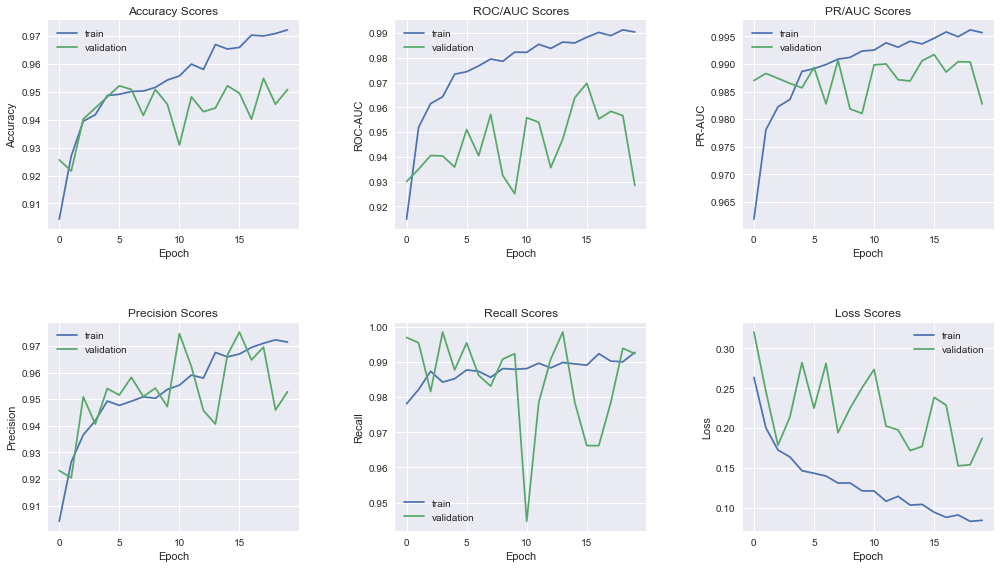

In [14]:
plt.style.use('seaborn')
sixplot(history5, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [15]:
hist_df_5 = pd.DataFrame(history5.history)
hist_df_5

,loss,accuracy,auc,auc_1,precision,recall,val_loss,val_accuracy,val_auc,val_auc_1,val_precision,val_recall
0,0.263628,0.904386,0.914857,0.961925,0.904119,0.978102,0.320652,0.925631,0.930062,0.986990,0.923186,0.996928
1,0.200123,0.927047,0.951962,0.978089,0.926436,0.982136,0.245897,0.921647,0.935047,0.988276,0.920455,0.995392
2,0.172380,0.939474,0.961540,0.982239,0.936589,0.987322,0.178408,0.940239,0.940551,0.987382,0.950893,0.981567
3,0.163577,0.941813,0.964281,0.983576,0.941912,0.984249,0.213996,0.944223,0.940386,0.986468,0.940666,0.998464
4,0.146326,0.948684,0.973403,0.988633,0.949287,0.985209,0.282331,0.948207,0.935913,0.985675,0.954006,0.987711
5,0.143126,0.949123,0.974407,0.989140,0.947659,0.987706,0.225005,0.952191,0.951078,0.989365,0.951542,0.995392
6,0.139611,0.950146,0.976753,0.989893,0.949215,0.987322,0.281093,0.950863,0.940484,0.982774,0.958209,0.986175
7,0.130796,0.950292,0.979544,0.990861,0.950890,0.985594,0.194230,0.941567,0.957147,0.990662,0.950966,0.983103
8,0.130912,0.951608,0.978615,0.991177,0.950305,0.988091,0.224719,0.950863,0.932547,0.981855,0.954142,0.990783
9,0.121000,0.954240,0.982310,0.992329,0.953644,0.987899,0.250473,0.945551,0.925123,0.981044,0.947214,0.992320


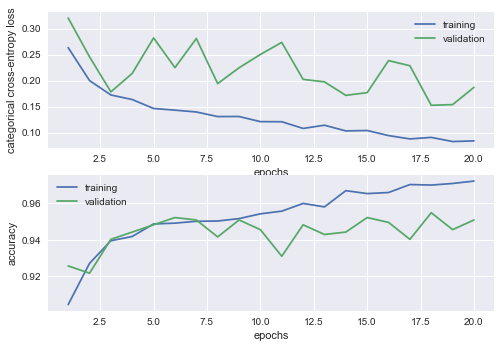

In [18]:
plt.style.use('seaborn')
train_val_metrics(20, history5)

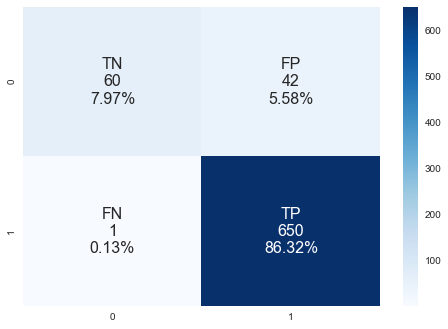

In [19]:
prob5 = model5.predict_generator(test_generator)
y_true = test_generator.classes
y_pred5 = prob5 > 0.5
make_confusion_matrix(y_true, y_pred5)

In [20]:
X_tt, y_tt = next(test_generator)

In [21]:
score = model5.evaluate(X_tt, y_tt, verbose = 1)
labels = model5.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

1/1 [==============================] - 2s 2s/step - loss: 1.1386 - accuracy: 0.2812 - auc: 0.0000e+00 - auc_1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00
loss: 1.1386468410491943
accuracy: 0.28125


In [22]:
y_score = model5.predict_proba(X_tt)
fpr, tpr, __ = roc_curve(y_tt, y_score)
roc_auc = auc(fpr, tpr)
prec,rec, __ = precision_recall_curve(y_tt, y_score)
pr_auc = auc(rec, prec)

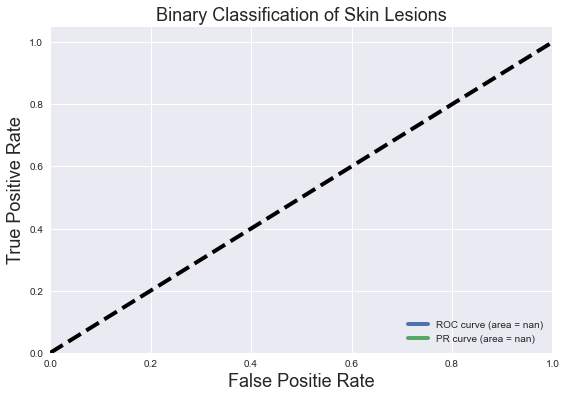

In [23]:
plt.figure(figsize = [9, 6])
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % roc_auc, linewidth = 4)
plt.plot(rec, prec, label = 'PR curve (area = %0.2f)' % pr_auc, linewidth = 4)
plt.plot([0, 1], [0, 1], 'k--', linewidth = 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positie Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('Binary Classification of Skin Lesions', fontsize = 18)
plt.legend(loc = 'lower right')
plt.show()